An end-to-end Bangalore house price prediction project involves data collection, preprocessing, feature engineering, model selection, training, and evaluation using machine learning algorithms. The project aims to predict house prices based on factors like location, size, and amenities, ensuring accurate, reliable forecasts to aid buyers and sellers in decision-making.

About the dataset: This dataset contains 13320 records of year 2017.
- **area_type**: different types of area measurements
- **availability**: when is it available to move in
- **location**- locality of Bangalore city
- **size**- tells us about bedroom hall and kitchen counts
- **society**- housing society
- **total_sqft**- total sqft area
- **bath**- number of bathrooms available
- **balcony**- number of balcony available
- **price**- price of the house to buy (in lakhs)

In [1]:
# importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# importing the dataset
bng = pd.read_csv('Bengaluru_House_Data.csv')
bng.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
bng.shape

(13320, 9)

In [4]:
# checking the info
bng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
bng.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


## EDA

In [6]:
# checking null values
bng.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

society column seems to have large number of null values, but the hard to understand. So, we can drop that column.

In [7]:
bng.drop(columns='society',inplace=True)

Among rest columns, area_type, availability and balcony seem to have less impact on price. So, we can drop them. But instead of dropping them, lets create a new dataframe without these columns.

In [8]:
bng_1 = bng.drop(columns=['area_type','availability','balcony'])
bng_1.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


We still have a few null values. Based on the number of records present(13320) 73 null values are fine to drop.

In [9]:
bng_1.dropna(inplace=True)
print('Null values:',bng_1.isnull().sum().sum())
print('Shape:',bng_1.shape)

Null values: 0
Shape: (13246, 5)


In [10]:
print('Duplicate values:',bng_1.duplicated().sum())

Duplicate values: 881


In [11]:
bng_1.drop_duplicates(inplace=True)
print('Shape of the dataset after dropping duplicate records:',bng_1.shape)

Shape of the dataset after dropping duplicate records: (12365, 5)


In [12]:
# summary statistic
bng_1.describe().T

,count,mean,std,min,25%,50%,75%,max
bath,12365.0,2.719693,1.369955,1.0,2.0,2.00,3.0,40.0
price,12365.0,115.229230,153.201909,8.0,50.0,73.87,123.0,3600.0


Size column contains records in object data type which can be avoided by converting them to int.

In [13]:
bng_1['bhk'] = bng_1['size'].apply(lambda x : int(x.split(' ')[0]))
bng_1

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2
...,...,...,...,...,...,...
13314,Green Glen Layout,3 BHK,1715,3.0,112.00,3
13315,Whitefield,5 Bedroom,3453,4.0,231.00,5
13316,Richards Town,4 BHK,3600,5.0,400.00,4
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00,2


Let's create a new column price per total sqft. Before that total_sqft data type need to be changed from str to float or int. And there are a few values which are present in range format and in sq meter, we need to convert them too.

In [14]:
import re
def convert_to_float(sqft):
    if isinstance(sqft,str): # checks if sqft is a string or not
        if '-' in sqft:
            sqft_range = list(map(float,sqft.split('-')))
            return (sqft_range[0] + sqft_range[1]) / 2
    
    # for those values which are present like '34.46Sq. Meter'
    numeric_values = re.findall(r'\d+\.?\d*', sqft)
    if numeric_values:
        numeric_value = float(numeric_values[0])
            
        # Convert units if necessary
        if 'Meter' in sqft:
            return numeric_value * 10.7639  # Convert square meters to square feet
        return numeric_value

bng_1['total_sqft_float'] = bng['total_sqft'].apply(convert_to_float)
bng_1.head()

,location,size,total_sqft,bath,price,bhk,total_sqft_float
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2,1056.0
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4,2600.0
2,Uttarahalli,3 BHK,1440,2.0,62.00,3,1440.0
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3,1521.0
4,Kothanur,2 BHK,1200,2.0,51.00,2,1200.0


In [15]:
bng_1['price_sqft'] = bng_1['price']/ bng_1['total_sqft_float']
bng_1.head()

,location,size,total_sqft,bath,price,bhk,total_sqft_float,price_sqft
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2,1056.0,0.036998
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4,2600.0,0.046154
2,Uttarahalli,3 BHK,1440,2.0,62.00,3,1440.0,0.043056
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3,1521.0,0.062459
4,Kothanur,2 BHK,1200,2.0,51.00,2,1200.0,0.042500


Lets convert price per sqft (in lakhs) to Rs.

In [16]:
bng_1['price_sqft'] = bng_1['price_sqft']*100000

In [17]:
bng_1.head()

,location,size,total_sqft,bath,price,bhk,total_sqft_float,price_sqft
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2,1056.0,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4,2600.0,4615.384615
2,Uttarahalli,3 BHK,1440,2.0,62.00,3,1440.0,4305.555556
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3,1521.0,6245.890861
4,Kothanur,2 BHK,1200,2.0,51.00,2,1200.0,4250.000000


In [18]:
# checking location counts
location_counts = pd.DataFrame(bng_1['location'].value_counts()).reset_index()
location_counts.columns = ['Location','Counts']
location_counts

,Location,Counts
0,Whitefield,501
1,Sarjapur Road,357
2,Electronic City,273
3,Thanisandra,223
4,Kanakpura Road,217
...,...,...
1299,Maruthi Extension,1
1300,Okalipura,1
1301,Old Town,1
1302,Vasantapura main road,1


In [19]:
location_counts[location_counts['Counts']<50]

,Location,Counts
44,Panathur,49
45,Jalahalli,48
46,Hegde Nagar,48
47,Gottigere,47
48,Brookefield,47
...,...,...
1299,Maruthi Extension,1
1300,Okalipura,1
1301,Old Town,1
1302,Vasantapura main road,1


From 1304 total location counts, 1260 locations has less than 50 house prices recorded in the dataset. We can drop these locations for easier EDA process. (Lets make a copy of the dataset while dropping)

In [20]:
new_location_counts = location_counts[location_counts['Counts']>50]
new_location_counts

,Location,Counts
0,Whitefield,501
1,Sarjapur Road,357
2,Electronic City,273
3,Thanisandra,223
4,Kanakpura Road,217
5,Yelahanka,206
6,Marathahalli,164
7,Raja Rajeshwari Nagar,153
8,Bannerghatta Road,149
9,Uttarahalli,143


Now we need to include those records whose location are present in this new_location_counts.

In [21]:
locationsss = new_location_counts['Location'].to_list()
locationsss

['Whitefield',
 'Sarjapur  Road',
 'Electronic City',
 'Thanisandra',
 'Kanakpura Road',
 'Yelahanka',
 'Marathahalli',
 'Raja Rajeshwari Nagar',
 'Bannerghatta Road',
 'Uttarahalli',
 'Hebbal',
 'Hennur Road',
 '7th Phase JP Nagar',
 'Electronic City Phase II',
 'Rajaji Nagar',
 'Bellandur',
 'KR Puram',
 'Hoodi',
 'Electronics City Phase 1',
 'Haralur Road',
 'Yeshwanthpur',
 'Sarjapur',
 'Kasavanhalli',
 'Harlur',
 'Kengeri',
 'Begur Road',
 'Hormavu',
 'Ramamurthy Nagar',
 'Koramangala',
 'Banashankari',
 'Varthur',
 'Hosa Road',
 'JP Nagar',
 'Chandapura',
 'Jakkur',
 'Kaggadasapura',
 'Old Madras Road',
 'Kothanur',
 'Nagarbhavi',
 'Akshaya Nagar',
 '8th Phase JP Nagar',
 'Malleshwaram',
 'Hulimavu']

In [22]:
bng_2 = bng_1[bng_1['location'].isin(locationsss)]
bng_2.shape

(4983, 8)

In [23]:
bng_2.head()

,location,size,total_sqft,bath,price,bhk,total_sqft_float,price_sqft
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2,1056.0,3699.810606
2,Uttarahalli,3 BHK,1440,2.0,62.00,3,1440.0,4305.555556
4,Kothanur,2 BHK,1200,2.0,51.00,2,1200.0,4250.000000
5,Whitefield,2 BHK,1170,2.0,38.00,2,1170.0,3247.863248
7,Rajaji Nagar,4 BHK,3300,4.0,600.00,4,3300.0,18181.818182


In [24]:
# dropping columns which are not needed further
bng_2.drop(columns=['size','total_sqft','price'], inplace=True)
bng_2.head()

C:\Users\Madhu\AppData\Local\Temp\ipykernel_17316\1919057821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bng_2.drop(columns=['size','total_sqft','price'], inplace=True)


,location,bath,bhk,total_sqft_float,price_sqft
0,Electronic City Phase II,2.0,2,1056.0,3699.810606
2,Uttarahalli,2.0,3,1440.0,4305.555556
4,Kothanur,2.0,2,1200.0,4250.000000
5,Whitefield,2.0,2,1170.0,3247.863248
7,Rajaji Nagar,4.0,4,3300.0,18181.818182


In [25]:
bng_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4983 entries, 0 to 13317
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          4983 non-null   object 
 1   bath              4983 non-null   float64
 2   bhk               4983 non-null   int64  
 3   total_sqft_float  4983 non-null   float64
 4   price_sqft        4983 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 233.6+ KB


Text(0.5, 1.0, 'Location distribution')

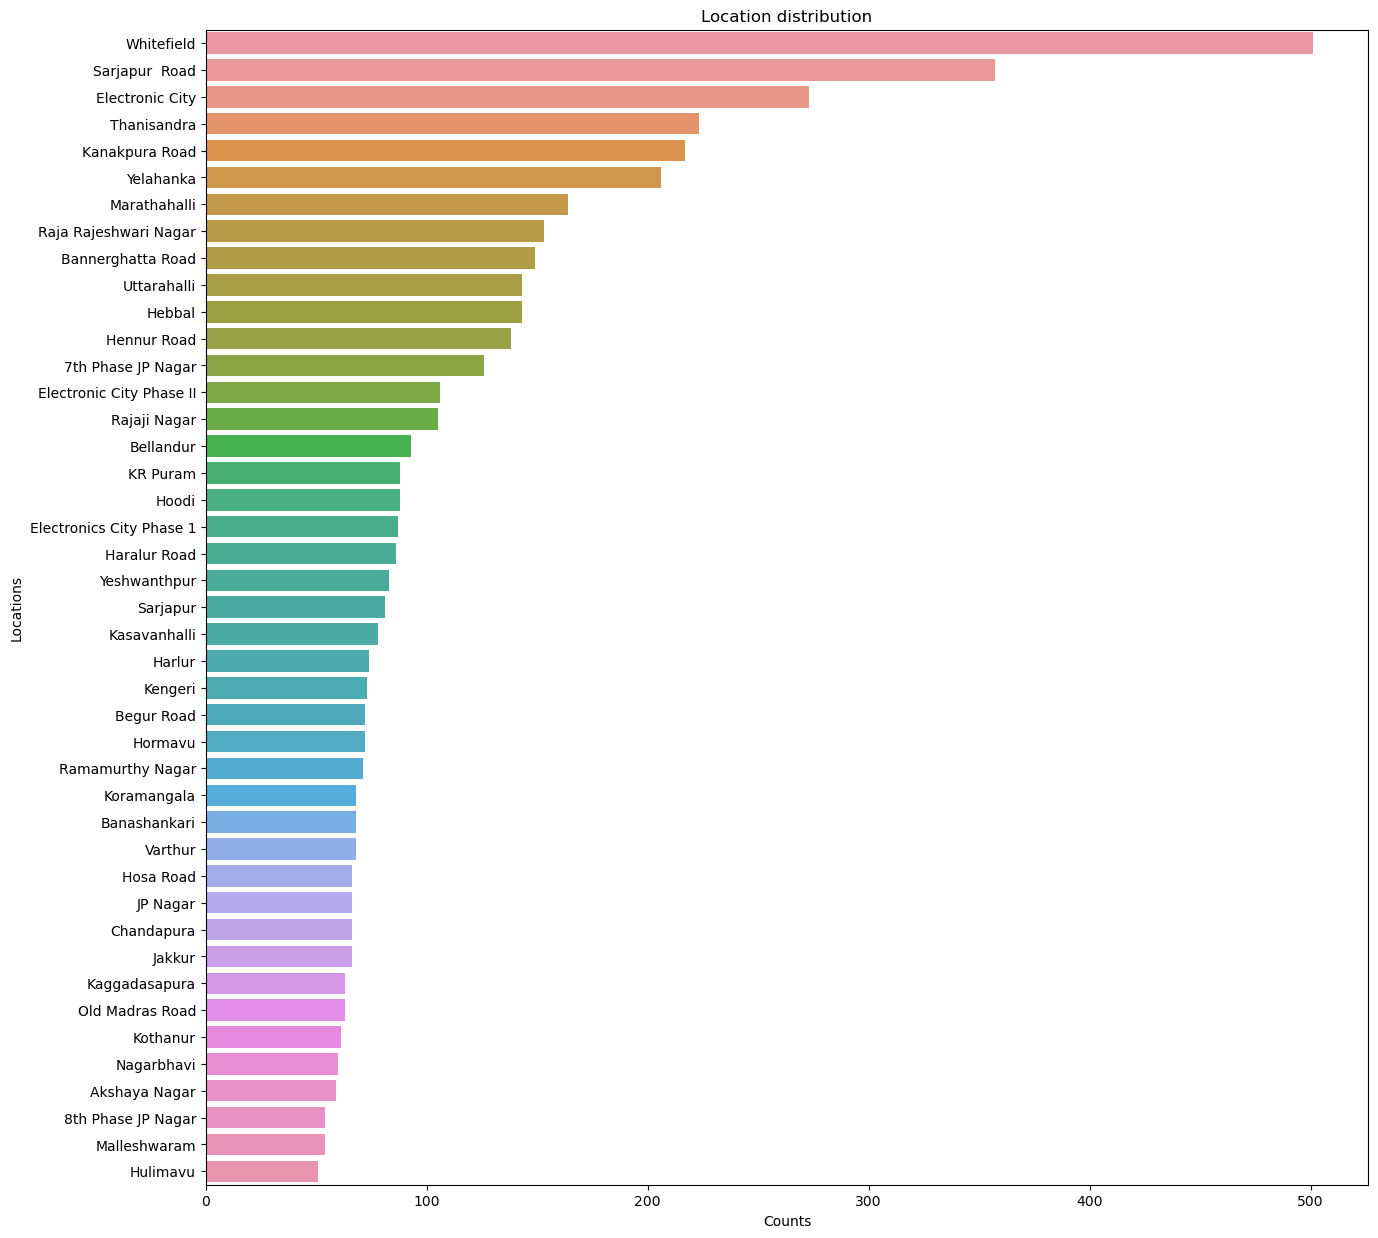

In [26]:
plt.figure(figsize=(15,15))
sns.barplot(data = new_location_counts, y = 'Location', x = 'Counts')
plt.ylabel('Locations')
plt.xlabel('Counts')
plt.title('Location distribution')

Target variable here is price per sqft which is in numeric data type. Hence, regression model will be used. But before that we need to check if there are any outliers present or not, and we need to encode the categorical feature (location).


In [27]:
# encoding the location column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

bng_2['location'] = le.fit_transform(bng_2['location'])
bng_2.head()

C:\Users\Madhu\AppData\Local\Temp\ipykernel_17316\3742784135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bng_2['location'] = le.fit_transform(bng_2['location'])


,location,bath,bhk,total_sqft_float,price_sqft
0,9,2.0,2,1056.0,3699.810606
2,38,2.0,3,1440.0,4305.555556
4,27,2.0,2,1200.0,4250.000000
5,40,2.0,2,1170.0,3247.863248
7,33,4.0,4,3300.0,18181.818182


In [28]:
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_mapping

{'7th Phase JP Nagar': 0,
 '8th Phase JP Nagar': 1,
 'Akshaya Nagar': 2,
 'Banashankari': 3,
 'Bannerghatta Road': 4,
 'Begur Road': 5,
 'Bellandur': 6,
 'Chandapura': 7,
 'Electronic City': 8,
 'Electronic City Phase II': 9,
 'Electronics City Phase 1': 10,
 'Haralur Road': 11,
 'Harlur': 12,
 'Hebbal': 13,
 'Hennur Road': 14,
 'Hoodi': 15,
 'Hormavu': 16,
 'Hosa Road': 17,
 'Hulimavu': 18,
 'JP Nagar': 19,
 'Jakkur': 20,
 'KR Puram': 21,
 'Kaggadasapura': 22,
 'Kanakpura Road': 23,
 'Kasavanhalli': 24,
 'Kengeri': 25,
 'Koramangala': 26,
 'Kothanur': 27,
 'Malleshwaram': 28,
 'Marathahalli': 29,
 'Nagarbhavi': 30,
 'Old Madras Road': 31,
 'Raja Rajeshwari Nagar': 32,
 'Rajaji Nagar': 33,
 'Ramamurthy Nagar': 34,
 'Sarjapur': 35,
 'Sarjapur  Road': 36,
 'Thanisandra': 37,
 'Uttarahalli': 38,
 'Varthur': 39,
 'Whitefield': 40,
 'Yelahanka': 41,
 'Yeshwanthpur': 42}

Text(0.5, 1.0, 'Price per sqft distribution')

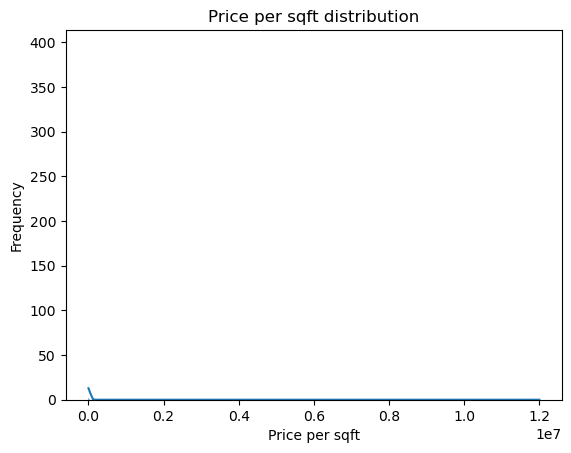

In [29]:
# checking the distribution of target feature
sns.histplot(bng_2['price_sqft'],kde=True)
plt.xlabel('Price per sqft')
plt.ylabel('Frequency')
plt.title('Price per sqft distribution')

<Axes: >

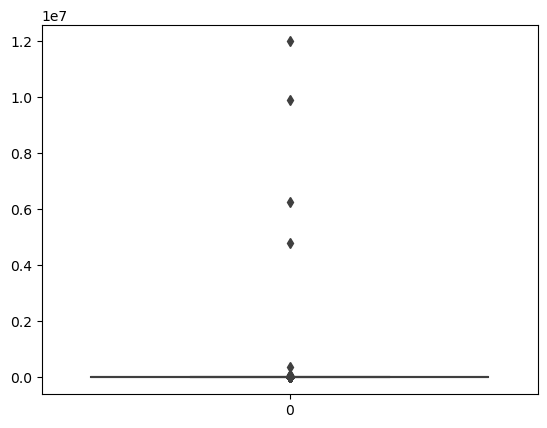

In [30]:
# check for presence of outliers
sns.boxplot(bng_2['price_sqft'])

Text(0.5, 1.0, 'Total sqft')

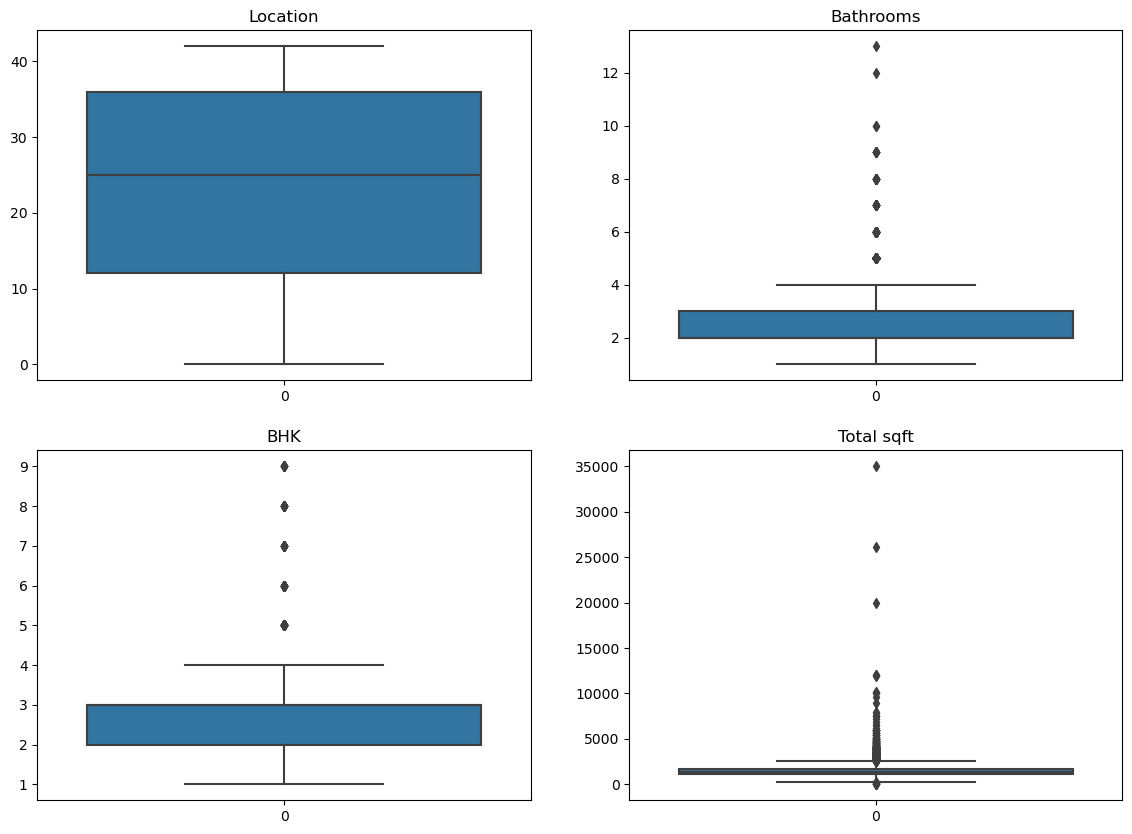

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,10))

sns.boxplot(bng_2['location'], ax = ax1)
ax1.set_title('Location')

sns.boxplot(bng_2['bath'], ax = ax2)
ax2.set_title('Bathrooms')

sns.boxplot(bng_2['bhk'], ax = ax3)
ax3.set_title('BHK')

sns.boxplot(bng_2['total_sqft_float'], ax = ax4)
ax4.set_title('Total sqft')

Target feature (price per sqft) along with total sqft feature has lots of outliers present.

In [32]:
lower_threshold = bng_2['price_sqft'].quantile(0.01)
upper_threshold = bng_2['price_sqft'].quantile(0.90)

bng_filtered = bng_2[(bng_2['price_sqft'] >= lower_threshold) & (bng_2['price_sqft'] <= upper_threshold)]

In [33]:
bng_filtered

,location,bath,bhk,total_sqft_float,price_sqft
0,9,2.0,2,1056.0,3699.810606
2,38,2.0,3,1440.0,4305.555556
4,27,2.0,2,1200.0,4250.000000
5,40,2.0,2,1170.0,3247.863248
8,29,3.0,3,1310.0,4828.244275
...,...,...,...,...,...
13304,32,2.0,2,1187.0,3381.634372
13309,42,3.0,3,1675.0,5500.298507
13312,6,2.0,2,1262.0,3724.247227
13315,40,4.0,5,3453.0,6689.834926


Text(0.5, 1.0, 'Total sqft')

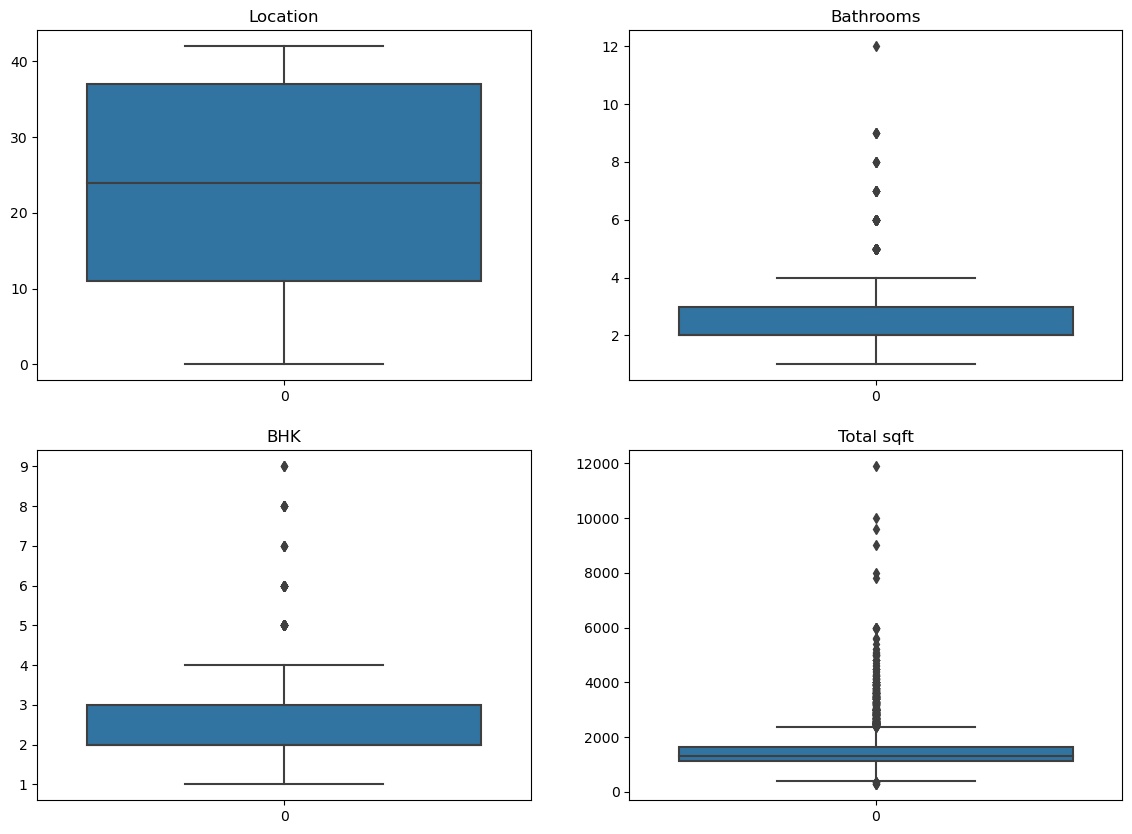

In [34]:
# after removing few outliers
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,10))

sns.boxplot(bng_filtered['location'], ax = ax1)
ax1.set_title('Location')

sns.boxplot(bng_filtered['bath'], ax = ax2)
ax2.set_title('Bathrooms')

sns.boxplot(bng_filtered['bhk'], ax = ax3)
ax3.set_title('BHK')

sns.boxplot(bng_filtered['total_sqft_float'], ax = ax4)
ax4.set_title('Total sqft')

In [35]:
X_filtered = bng_filtered.drop(columns = 'price_sqft')
Y_filtered = bng_filtered['price_sqft']

<Axes: >

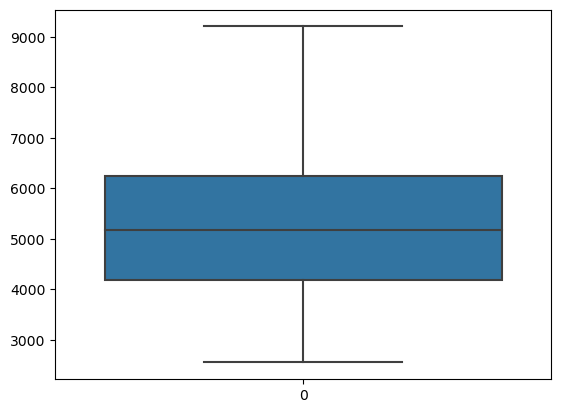

In [36]:
sns.boxplot(Y_filtered)

Text(0.5, 1.0, 'Price per sqft distribution (after removing outliers)')

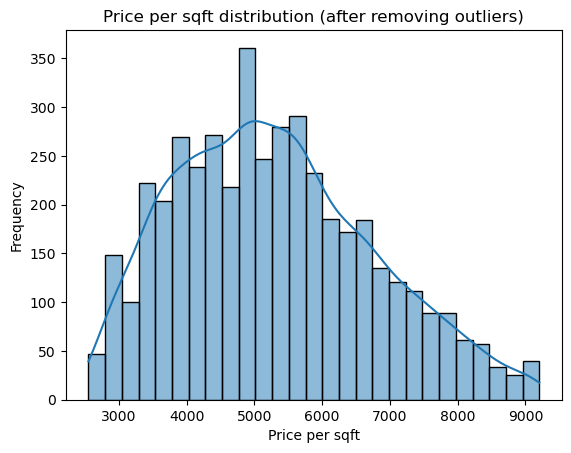

In [37]:
sns.histplot(Y_filtered,kde=True)
plt.xlabel('Price per sqft')
plt.ylabel('Frequency')
plt.title('Price per sqft distribution (after removing outliers)')

After removing outliers, target feature seems to be normally distributed now (still a little bit right skewed due to presence of few outliers.)

In [38]:
Y_filtered.shape

(4434,)

### Train Test Split

In [39]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_filtered, Y_filtered, test_size = 0.3, random_state = 32)

print('xtrain:', xtrain.shape)
print('ytrain:', ytrain.shape)
print('xtest:', xtest.shape)
print('ytest:', ytest.shape)

xtrain: (3103, 4)
ytrain: (3103,)
xtest: (1331, 4)
ytest: (1331,)


### Linear Regression model training

In [40]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

reg.fit(xtrain, ytrain)

LinearRegression()

In [41]:
ypred_reg = reg.predict(xtest)

### Random Forest Regression model training

In [42]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

rfreg.fit(xtrain, ytrain)

RandomForestRegressor()

In [43]:
ypred_rfreg = rfreg.predict(xtest)

### Evaluating model performance

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
# mse
print('Mean Squared error of LINEAR REGRESSION model:', mean_squared_error(ytest,ypred_reg))
print('Mean Squared error of RANDOM FOREST REGRESSION model:', mean_squared_error(ytest,ypred_rfreg))

Mean Squared error of LINEAR REGRESSION model: 1837975.626039966
Mean Squared error of RANDOM FOREST REGRESSION model: 1328227.2437396075


In [46]:
# rmse
print('Root Mean Squared error of LINEAR REGRESSION model:', mean_squared_error(ytest,ypred_reg, squared = False))
print('Root Mean Squared error of RANDOM FOREST REGRESSION model:', mean_squared_error(ytest,ypred_rfreg, squared = False))

Root Mean Squared error of LINEAR REGRESSION model: 1355.7195971291283
Root Mean Squared error of RANDOM FOREST REGRESSION model: 1152.4874158703892


In [47]:
# r2 score
print('r2 score of LINEAR REGRESSION model:', r2_score(ytest,ypred_reg))
print('r2 score of RANDOM FOREST REGRESSION model:', r2_score(ytest,ypred_rfreg))

r2 score of LINEAR REGRESSION model: 0.12908476946319059
r2 score of RANDOM FOREST REGRESSION model: 0.3706264001557562


Conclusion is in the html page.